# Fully Conv

## Create Data

In [1]:
%matplotlib inline

from random import choice, randrange
import os
import numpy as np
import sys
#sys.argv.append('--dynet_mem')
#sys.argv.append('6000')
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import _gdynet as dy
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

dy.init()

embed_size = 64
filter_width = 3
encoder_depth = 1
decoder_depth = 1


#os.environ["CUDA_VISIBLE_DEVICES"]="1"
PAD = "<PAD>" #all strings will end with the End Of String token
EOS = "<EOS>"
characters = list("abcd") + [PAD, EOS]


int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)

def sample_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)                             # Pick a random length
    random_char_list = [choice(characters[:-2]) for _ in range(random_length)]  # Pick random chars
    random_string = ''.join(random_char_list) 
    return random_string, random_string[::-1]  # Return the random string and its reverse

MAX_STRING_LEN = 10

train_set = [sample_model(1, MAX_STRING_LEN) for _ in range(3000)]
val_set = [sample_model(1, MAX_STRING_LEN) for _ in range(50)]

## Train Func

In [2]:
def train(network, train_set, val_set, epochs = 20):
    def get_val_set_loss(network, val_set):
        dy.renew_cg()
        loss = [network.get_loss(input_string, output_string).value() for input_string, output_string in val_set]
        return sum(loss)
    
    train_set = train_set*epochs
    trainer = dy.SimpleSGDTrainer(network.model)
    losses = []
    iterations = []
    for i, training_example in enumerate(tqdm(train_set)):
        input_string, output_string = training_example
        dy.renew_cg()
        loss = network.get_loss(input_string, output_string)
        loss_value = loss.value()
        loss.backward()
        trainer.update()

        # Accumulate average losses over training to plot
        if i%(len(train_set)/100) == 0:
            val_loss = get_val_set_loss(network, val_set)
            losses.append(val_loss)
            iterations.append(i/((len(train_set)/100)))
            print(val_loss)

    plt.plot(iterations, losses)
    plt.axis([0, 100, 0, len(val_set)*MAX_STRING_LEN])
    plt.show() 
    print('loss on validation set:', val_loss)

In [3]:
def pp(expr):
    print(expr.npvalue().shape)

## The Model

In [4]:
class ConvAtt:
    def params(self, size):
        return self.model.add_parameters(size)

    def get_conv_filters(self, filter_size, embeddings_size):
        f_a = self.params((1, filter_size, embeddings_size, embeddings_size))
        b_a = self.params((embeddings_size))
        f_b = self.params((1, filter_size, embeddings_size, embeddings_size))
        b_b = self.params((embeddings_size))
        return f_a, b_a, f_b, b_b

    def __init__(self, embeddings_size, filter_size, enc_layers, dec_layers):
        self.embeddings_size = embeddings_size

        self.model = dy.Model()

        self.word_embeddings = self.model.add_lookup_parameters((VOCAB_SIZE, embeddings_size))
        self.position_embeddings = self.model.add_lookup_parameters((MAX_STRING_LEN + 2, embeddings_size))

        self.enc_filters = []
        for _ in range(enc_layers):
            f_a, b_a, f_b, b_b = self.get_conv_filters(filter_size, embeddings_size)
            self.enc_filters.append((f_a, b_a, f_b, b_b))

        self.dec_filters = []
        self.att_ws = []
        self.att_bs = []
        for _ in range(dec_layers):
            f_a, b_a, f_b, b_b = self.get_conv_filters(filter_size, embeddings_size)
            self.dec_filters.append((f_a, b_a, f_b, b_b))
            self.att_ws.append(self.params((1, 1, embeddings_size, embeddings_size)))
            self.att_bs.append(self.params((embeddings_size)))

        self.output_w = self.params((VOCAB_SIZE, embeddings_size))
        self.output_b = self.params((VOCAB_SIZE))

    def GLU(self, A, B):
        return dy.cmult(A, dy.logistic(B))

    def conv_block(self, f, block_input):
        f_a, b_a, f_b, b_b = f

        f_a = dy.parameter(f_a)
        b_a = dy.parameter(b_a)
        f_b = dy.parameter(f_b)
        b_b = dy.parameter(b_b)

        conv_output_a = dy.conv2d_bias(block_input, f_a, b_a, [1, 1], is_valid=False)
        conv_output_b = dy.conv2d_bias(block_input, f_b, b_b, [1, 1], is_valid=False)
        conv_output = self.GLU(conv_output_a, conv_output_b)
        return conv_output

    def embedd(self, string):
        seq_len = len(string)
        positions = [i for i in range(seq_len)]

        embedded_string =  dy.lookup_batch(self.word_embeddings, string)
        embedded_positions = dy.lookup_batch(self.position_embeddings, positions)

        summ = dy.reshape(embedded_string + embedded_positions, (self.embeddings_size, seq_len))
        return dy.transpose(summ), seq_len

    def encode(self, input_string):
        embedded, seq_len = self.embedd(input_string)
        conv_input = dy.reshape(embedded, (1, seq_len, self.embeddings_size))

        for enc_filter in self.enc_filters:
            conv_input = self.conv_block(enc_filter, conv_input) + conv_input
        return conv_input

    def step_attention(self, conv_block_out, encoded, w, b, last_ws, seq_len, input_len):
        w = dy.parameter(w)
        b = dy.parameter(b)

        #ds = [w * h + b + last_w for h, last_w in zip(conv_block_out[0], last_ws)]
        ds = dy.conv2d_bias(conv_block_out, w, b, [1, 1], is_valid=False)
        ds = dy.reshape(ds, (seq_len, self.embeddings_size)) + last_ws
        # TODO replace with conv
        aij = []
        for d in ds:
            d = dy.reshape(dy.transpose(d), (1, 1, self.embeddings_size, 1))
            d = dy.conv2d(encoded, d, [1, 1], is_valid=False)
            d = dy.reshape(d, (input_len, ))
            aij.append(dy.softmax(d))

        cs = [dy.esum([z * a for a, z in zip(ai, encoded[0])]) for ai in aij]
        cs = dy.reshape(dy.transpose(dy.concatenate_cols(cs)), (1, seq_len, self.embeddings_size))
        return cs

    def decode(self, current_out, encoded, input_len):
        embedded, seq_len = self.embedd(current_out)
        conv_input = dy.reshape(embedded, (1, seq_len, self.embeddings_size))

        for dec_filter, att_w, att_b in zip(self.dec_filters, self.att_ws, self.att_bs):
            conv_block_out = self.conv_block(dec_filter, conv_input)
            conv_input = self.step_attention(conv_block_out, encoded, att_w, att_b, embedded, seq_len, input_len) + conv_input
        return conv_input

    def str2ints(self, string):
        return [char2int[c] for c in [PAD] + list(string) + [EOS]]

    def get_loss(self, input_string, output_string):
        input_string = self.str2ints(input_string)
        output_string = self.str2ints(output_string)

        w = dy.parameter(self.output_w)
        b = dy.parameter(self.output_b)

        encoded = self.encode(input_string)

        loss = []
        for j in range(1, len(output_string)):
            decoded = self.decode(output_string[:j], encoded, len(input_string))
            probs = dy.softmax(w * decoded[0][-1] + b)
            loss.append(-dy.log(dy.pick(probs, output_string[j])))
        decoded = self.decode(output_string, encoded, len(input_string))
        probs = dy.softmax(w * decoded[0][-1] + b)
        loss.append(-dy.log(dy.pick(probs, char2int[PAD])))
        return dy.esum(loss)

    def generate(self, input_string):
        input_string = self.str2ints(input_string)

        w = dy.parameter(self.output_w)
        b = dy.parameter(self.output_b)

        encoded = self.encode(input_string)
        output_string = [char2int[PAD]]
        for _ in range(MAX_STRING_LEN + 2):
            decoded = self.decode(output_string, encoded, len(input_string))
            probs = dy.softmax(w * decoded[0][-1] + b)
            next_char = np.argmax(probs.npvalue())
            output_string.append(next_char)
            if int2char[next_char] == EOS:
                break

        return [int2char[char] for char in output_string]

In [5]:
conv = ConvAtt(embed_size, filter_width, encoder_depth, decoder_depth)
print(conv.generate('ab'))

['<PAD>', 'a', '<EOS>']


Widget Javascript not detected.  It may not be installed or enabled properly.


626.0804858207703
128.76934001035988
92.33988659922034
95.39406282547861
74.27524198172614
79.38339770282619
83.8286906973226
88.74517221743008
77.51200671342667
42.320964167360216
29.21646802977193
73.60348944843281
109.26427455624798
55.324185049626976
88.91703183966456
60.93847794964677
96.77767056037555
73.34449432732072
66.24782918806886
60.24582437786739
78.53890486934688
90.29901527264155
85.29618191713234
66.45439828146482
67.68811611861747
66.0635716712568
90.10151278086414
113.16611401893897
67.17142644255364
46.46841103665065
60.25567701632099
94.58197902789107
67.37946464832203
79.5451364548644
63.53223397413967
81.9246325052809
71.30212353990646
76.65589481635834
60.95397530274931
65.97349572128587
93.25532698692405
78.07555549130484
56.458443375799106
62.70230772704235
56.13537282650941
74.5004115660995
57.52689387139981
53.901951757768984
86.62018413146143
39.562410908525635
56.24597244770848
95.0363859312929
35.05637357015803
43.594944088719785
53.92813585343538
60.2627

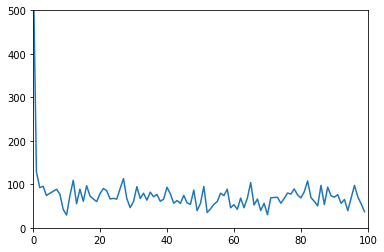

loss on validation set: 37.012838207891036


In [6]:
train(conv, train_set, val_set)

In [7]:
print(conv.generate('abcd'))

['<PAD>', 'd', 'c', 'b', 'a', '<EOS>']
